### [05/02/22] CIFAR10 ResNet20 Successive IMP Optima LMC

In [79]:
from composer.datasets import DataLoaderHparams
from composer.utils.object_store import ObjectStoreProviderHparams
from lth_diet.data import CIFAR10DataHparams
from lth_diet.exps import LotteryExperiment
from lth_diet.models import ResNetCIFARClassifierHparams
from lth_diet.utils import utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import torch
from tqdm import tqdm
plt.style.use("default")
rc = {"figure.figsize": (4, 3), "figure.dpi": 150, "figure.constrained_layout.use": True, "axes.grid": True, 
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.6, "grid.linewidth": 0.6,
      "xtick.major.width": 0.6, "ytick.major.width": 0.6, "xtick.major.size": 4, "ytick.major.size": 4, 
      "axes.labelsize": 11, "axes.titlesize": 11, "xtick.labelsize": 10, "ytick.labelsize": 10,
      "axes.titlepad": 4, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1.2, 'lines.markeredgecolor': 'w', "patch.linewidth": 0}
sns.set_theme(style='ticks', palette=sns.color_palette("tab10"), rc=rc)
object_store = ObjectStoreProviderHparams('google_storage', 'prunes', 'GCS_KEY').initialize_object()
bucket_dir = os.environ['OBJECT_STORE_DIR']

In [2]:
torch.set_grad_enabled(False)

In [3]:
config = f"../configs/lottery_test.yaml"
exp = LotteryExperiment.create(f=config, cli_args=False)
print(exp.name)

Lottery(model=ResNetCIFAR(num_classes=10,num_layers=20),train_data=CIFAR10(train=True),train_batch_size=128,optimizer=SGDHparams(lr=0.1,momentum=0.9,weight_decay=0.0001,dampening=0.0,nesterov=False),schedulers=[MultiStepSchedulerHparams(milestones=[31200ba,46800ba],gamma=0.1)],max_duration=62400ba,seed=6174,rewinding_steps=0ba,pruning=PruningHparams(pruning_fraction=0.2),algorithms=[ChannelsLastHparams()],callbacks=[LRMonitorHparams()])


In [4]:
rewinding_steps = np.array([0, 100, 250, 500, 1000, 2000])
replicates = np.arange(4)
levels = np.arange(15)
data = CIFAR10DataHparams(False).initialize_object(2000, DataLoaderHparams(persistent_workers=False))
model = ResNetCIFARClassifierHparams(10, 20).initialize_object()

In [5]:
def load_state_dict(exp, replicate, level, object_store):
    location = os.path.join(utils.get_hash(exp.name), f"replicate_{replicate}", f"level_{level}", "main")
    state_dict = utils.load_object(location, "model_final.pt", object_store, torch.load)
    return state_dict

def get_test_acc(model, data):
    model.cuda()
    model.eval()
    correct = 0
    for batch in data:
        batch = batch[0].cuda(), batch[1].cuda()
        logits = model(batch)
        correct += (logits.argmax(dim=-1) == batch[1]).sum()
    return correct / len(data.dataset)

def midpoint(state_dict, state_dict_):
    state_dict__ = {}
    for k, v in state_dict.items():
        state_dict__[k] = (v + state_dict_[k]) / 2
    return state_dict__

In [6]:
accs_srl = []
for rewind_step in tqdm(rewinding_steps):
    exp.rewinding_steps = f"{rewind_step}ba"
    accs_rl = []
    for rep in replicates:
        accs_l = []
        for lvl in levels:
            # k
            state_dict = load_state_dict(exp, rep, lvl, object_store)
            model.module.load_state_dict(state_dict)
            test_acc = get_test_acc(model, data)
            accs_l.append(test_acc)
            # (k + (k+1))/2
            state_dict_ = load_state_dict(exp, rep, lvl+1, object_store)
            state_dict__ = midpoint(state_dict, state_dict_)
            model.module.load_state_dict(state_dict__)
            test_acc = get_test_acc(model, data)
            accs_l.append(test_acc)
        # last level
        model.module.load_state_dict(state_dict_)
        test_acc = get_test_acc(model, data)
        accs_l.append(test_acc)
        accs_rl.append(accs_l)
    accs_srl.append(accs_rl)
accs_srl = torch.tensor(accs_srl).numpy()

100%|██████████| 6/6 [21:57<00:00, 219.51s/it]


In [90]:
errors_lr = 1 - accs_srl[-1].T

Text(0.5, 1.0, 'CIFAR10 ResNet20')

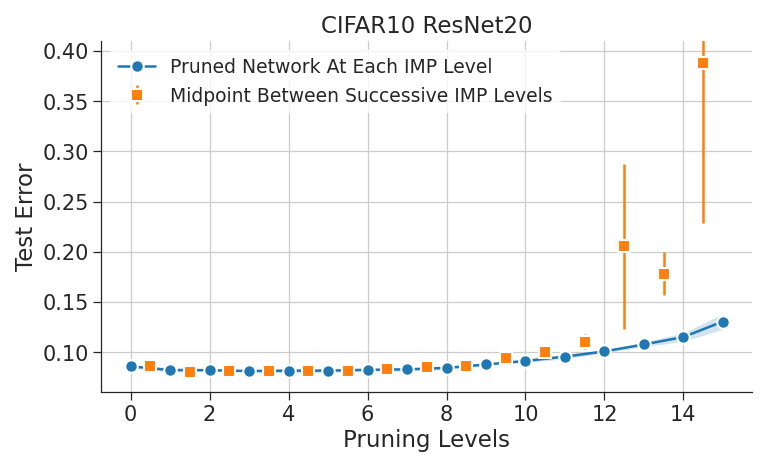

In [91]:
fig, axes = plt.subplots(dpi=150, figsize=(5, 3))
ls = []
ax = axes
x, ys = np.arange(errors_lr.shape[0])/2, errors_lr
ym, ye = ys.mean(-1), ys.std(-1)
ax.plot(x[::2], ym[::2], marker='o', label="Pruned Network At Each IMP Level")
ax.fill_between(x[::2], ym[::2]+ye[::2], ym[::2]-ye[::2], alpha=0.2)
ax.errorbar(x[1::2], ym[1::2], yerr=ye[1::2], marker='s', ls="", label="Midpoint Between Successive IMP Levels")
ax.set_ylim(0.06, 0.41)
ax.set_xlabel("Pruning Levels")
ax.set_ylabel("Test Error")
ax.legend(fontsize=9)
ax.set_title("CIFAR10 ResNet20")

In [92]:
errs_slr = 1 - accs_srl.transpose(0, 2, 1)

Text(0.5, 1.0, 'CIFAR10 ResNet20')

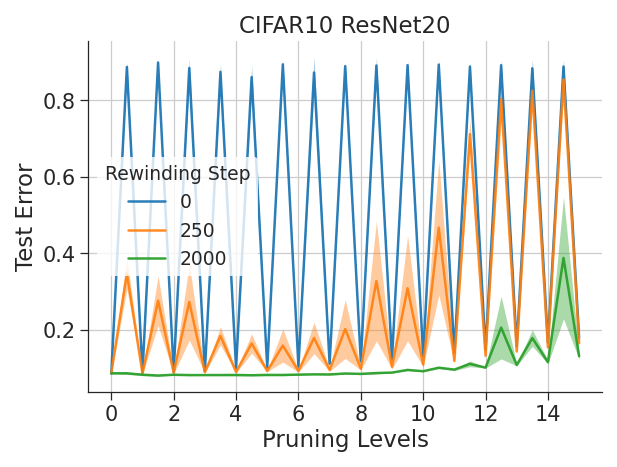

In [102]:
fig, axes = plt.subplots(dpi=150)
ls = []
ax = axes
x, ys = np.arange(errs_slr.shape[1])/2, errs_slr[0]
ym, ye = ys.mean(-1), ys.std(-1)
ax.plot(x, ym, alpha=0.95, label=rewinding_steps[0])
ax.fill_between(x, ym-ye, ym+ye, alpha=0.4)
x, ys = np.arange(errs_slr.shape[1])/2, errs_slr[2]
ym, ye = ys.mean(-1), ys.std(-1)
ax.plot(x, ym, alpha=0.9, label=rewinding_steps[2])
ax.fill_between(x, ym-ye, ym+ye, alpha=0.4)
x, ys = np.arange(errs_slr.shape[1])/2, errs_slr[5]
ym, ye = ys.mean(-1), ys.std(-1)
ax.plot(x, ym, alpha=0.95, label=rewinding_steps[5])
ax.fill_between(x, ym-ye, ym+ye, alpha=0.4)
ax.legend(fontsize=9, title="Rewinding Step", title_fontsize=9, loc=6)
plt.xticks(np.arange(8)*2)
ax.set_xlabel("Pruning Levels")
ax.set_ylabel("Test Error")
ax.set_title("CIFAR10 ResNet20")